# Autoencoders for Collaborative Filtering

In [2]:
import torch
import pandas as pd
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('../../data/lens_tmdb/ratings_small.csv')

In [4]:
ratings_df = data[['userId', 'movieId', 'rating']]

In [5]:
ratings_df['rating'] = ratings_df['rating'].apply(lambda x: 1 if x >= 4 else 0)


/tmp/ipykernel_6918/1744291944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['rating'] = ratings_df['rating'].apply(lambda x: 1 if x >= 4 else 0)


In [6]:
user_enc = LabelEncoder()
ratings_df['userId'] = user_enc.fit_transform(ratings_df['userId'].values)

item_enc = LabelEncoder()
ratings_df['movieId'] = item_enc.fit_transform(ratings_df['movieId'].values)


/tmp/ipykernel_6918/3728636018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['userId'] = user_enc.fit_transform(ratings_df['userId'].values)
/tmp/ipykernel_6918/3728636018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['movieId'] = item_enc.fit_transform(ratings_df['movieId'].values)


## Split the Data into Train and Test

In [7]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)


## Create Dataloaders

In [8]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings_df, num_users, num_items):
        self.users = ratings_df['userId'].values.astype(np.int64)
        self.items = ratings_df['movieId'].values.astype(np.int64)
        self.ratings = ratings_df['rating'].values.astype(np.float32)

        self.num_users = num_users
        self.num_items = num_items

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]


In [9]:
num_users = ratings_df['userId'].nunique()
num_items = ratings_df['movieId'].nunique()

train_dataset = MovieLensDataset(train_df, num_users, num_items)
test_dataset = MovieLensDataset(test_df, num_users, num_items)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024)


# Create Model Architecture

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, users, items):
        user_emb = self.user_emb(users)
        item_emb = self.item_emb(items)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.sigmoid(x).squeeze()


### Metrics

In [11]:
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred)**2)

# Train the Model and Evaluate

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(num_users, num_items, embedding_dim=50, hidden_dim=100).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_losses = []
test_losses = []
maes = []
rmses = []
mses = []
train_maes = []
train_rmses = []
train_mses = []


num_epochs = 10
# ...
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_mae_accum = 0.0
    train_rmse_accum = 0.0
    train_mse_accum = 0.0

    for users, items, ratings in train_loader:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)

        optimizer.zero_grad()
        outputs = model(users, items)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae_accum += mae(ratings, outputs).item()
        train_rmse_accum += rmse(ratings, outputs).item()
        train_mse_accum += mse(ratings, outputs).item()

    train_loss /= len(train_loader) # calculate average loss per epoch
    train_losses.append(train_loss)

    train_mae_accum /= len(train_loader)
    train_maes.append(train_mae_accum)

    train_rmse_accum /= len(train_loader)
    train_rmses.append(train_rmse_accum)

    train_mse_accum /= len(train_loader)
    train_mses.append(train_mse_accum)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')
    print(f'Training MAE: {train_mae_accum}')
    print(f'Training RMSE: {train_rmse_accum}')
    print(f'Training MSE: {train_mse_accum}')

    # ... rest of the code remains the same

    model.eval()
    test_loss = 0
    test_mae = 0
    test_rmse = 0
    test_mse = 0

    with torch.no_grad():
        for users, items, ratings in test_loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)

            outputs = model(users, items)
            loss = criterion(outputs, ratings)

            test_loss += loss.item()
            test_mae += mae(ratings, outputs).item()
            test_rmse += rmse(ratings, outputs).item()
            test_mse += mse(ratings, outputs).item()


        test_loss /= len(test_loader) # calculate average test loss per epoch
        test_losses.append(test_loss)

        test_mae /= len(test_loader) # calculate average mae per epoch
        maes.append(test_mae)

        test_rmse /= len(test_loader) # calculate average rmse per epoch
        rmses.append(test_rmse)

        test_mse /= len(test_loader) # calculate average mse per epoch
        mses.append(test_mse)

    print(f'Test Loss: {test_loss}')
    print(f'Test MAE: {test_mae}')
    print(f'Test RMSE: {test_rmse}')
    print(f'Test MSE: {test_mse}')




Epoch 1/10, Train Loss: 0.6307107942013801
Training MAE: 0.4398861414269556
Training RMSE: 0.4693533057653451
Training MSE: 0.2205564868223818
Test Loss: 0.5931763142347336
Test MAE: 0.3962880834937096
Test RMSE: 0.45114488899707794
Test MSE: 0.20357103869318963
Epoch 2/10, Train Loss: 0.5587301186368435
Training MAE: 0.3769326074213921
Training RMSE: 0.4345147092885609
Training MSE: 0.18884958421127707
Test Loss: 0.5704708456993103
Test MAE: 0.38447162210941316
Test RMSE: 0.44047478288412095
Test MSE: 0.19404939338564872
Epoch 3/10, Train Loss: 0.5209131719945352
Training MAE: 0.3465536810174773
Training RMSE: 0.41636743575711793
Training MSE: 0.17343957005422325
Test Loss: 0.5826898872852325
Test MAE: 0.36962811201810836
Test RMSE: 0.4437514364719391
Test MSE: 0.1969465970993042
Epoch 4/10, Train Loss: 0.49419454041915606
Training MAE: 0.3262428641319275
Training RMSE: 0.4040387287924561
Training MSE: 0.1633133856178839
Test Loss: 0.5803548246622086
Test MAE: 0.3750674292445183
Test 

# Visualize the Losses

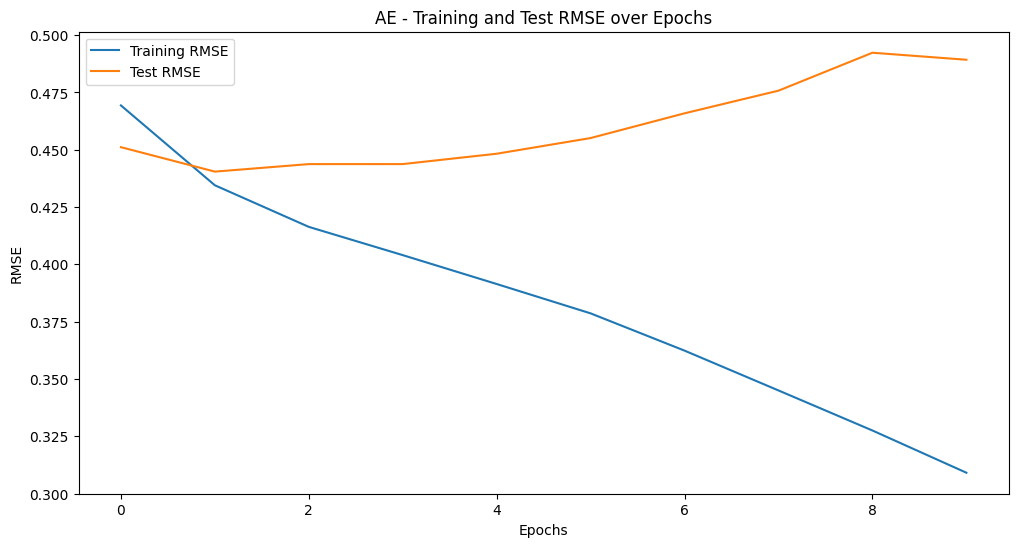

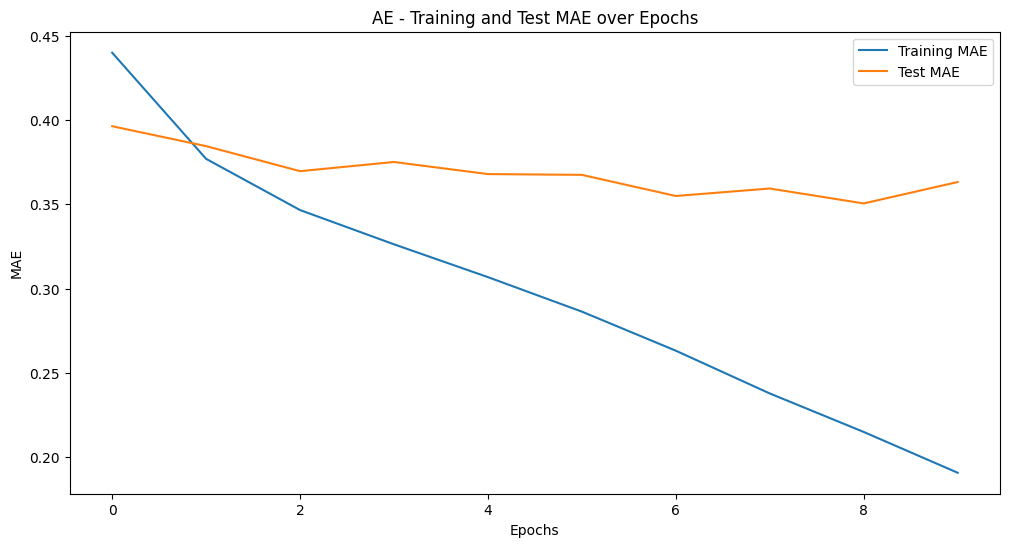

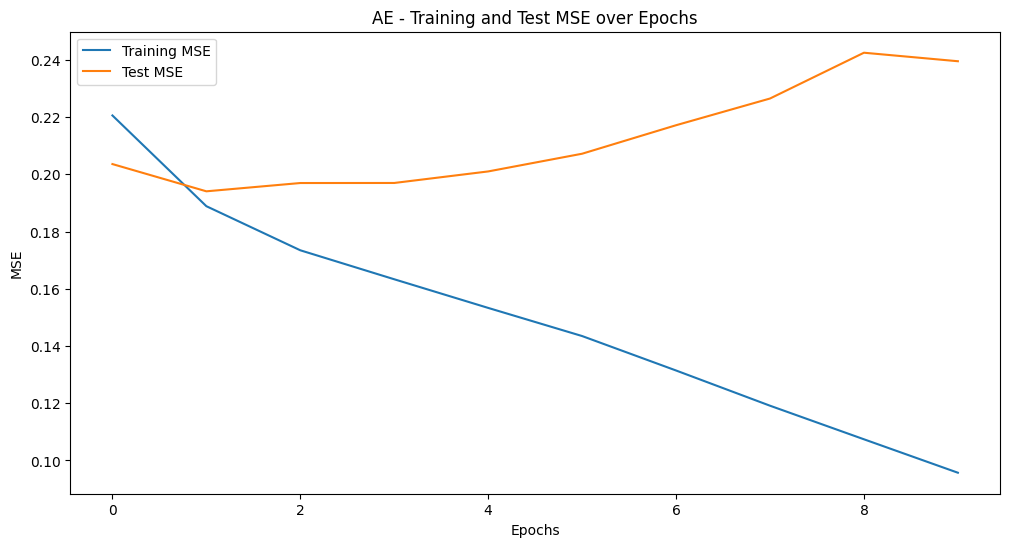

In [13]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
output_folder = "../../metrics/overleaf"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define model name
model_name = "AE"

# Visualization

# RMSE plot
plt.figure(figsize=(12, 6))
plt.plot(train_rmses, label='Training RMSE') # Corrected this line
plt.plot(rmses, label='Test RMSE') # Corrected this line
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title(f'{model_name} - Training and Test RMSE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_rmse_plot.png'))  # Save the figure
plt.show()

# MAE plot
plt.figure(figsize=(12, 6))
plt.plot(train_maes, label='Training MAE')
plt.plot(maes, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title(f'{model_name} - Training and Test MAE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_mae_plot.png'))  # Save the figure
plt.show()

# MSE plot
plt.figure(figsize=(12, 6))
plt.plot(train_mses, label='Training MSE')
plt.plot(mses, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title(f'{model_name} - Training and Test MSE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_mse_plot.png'))  # Save the figure
plt.show()
